# Transfer learning with Keras

Based on https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d,
as discussed on the [Keras blog](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) ("Building powerful image classification models using very little data")

It uses data that can be downloaded at:
https://www.kaggle.com/c/dogs-vs-cats/data

In our setup, we:
- created a data/ folder
- created train/ and validation/ subfolders inside data/
- created cats/ and dogs/ subfolders inside train/ and validation/
- put the cat pictures index 0-999 in data/train/cats
- put the cat pictures index 1000-1400 in data/validation/cats
- put the dogs pictures index 12500-13499 in data/train/dogs
- put the dog pictures index 13500-13900 in data/validation/dogs
So that we have 1000 training examples for each class, and 400 validation examples for each class.
In summary, this is our directory structure:

```
data/
    train/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
    validation/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
```


In [6]:
# for DSX, need to switch to the right directory. Detect using path name.
s = %pwd
if s.startswith('/gpfs'):
    %cd ~/deep-learning-workshop/

/gpfs/global_fs01/sym_shared/YPProdSpark/user/sf43-5b3dded8612265-7cbe6a591d13/deep-learning-workshop


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image

# for making plots prettier
import seaborn as sns 
sns.set_style('white')

In [3]:
from __future__ import print_function
np.random.seed(1331)  # for reproducibility

In [4]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras import optimizers

Using TensorFlow backend.


In [7]:
from display import visualize_keras_model, plot_training_curves

In [8]:
data_root = os.path.expanduser("~/data/cats_dogs")
train_data_dir = os.path.join(data_root, 'train')
validation_data_dir = os.path.join(data_root, 'validation')

In [10]:
# Make sure we have the expected numbers of images (1000 per class train, 400 validation)
for d in [train_data_dir, validation_data_dir]:
    for category in ['cats', 'dogs']:
        print("{}/{}: {}".format(
                d, category, len(os.listdir(os.path.join(d, category)))))

/gpfs/fs01/user/sf43-5b3dded8612265-7cbe6a591d13/data/cats_dogs/train/cats: 1000
/gpfs/fs01/user/sf43-5b3dded8612265-7cbe6a591d13/data/cats_dogs/train/dogs: 1000
/gpfs/fs01/user/sf43-5b3dded8612265-7cbe6a591d13/data/cats_dogs/validation/cats: 400
/gpfs/fs01/user/sf43-5b3dded8612265-7cbe6a591d13/data/cats_dogs/validation/dogs: 400


Let's look at a few of the images...

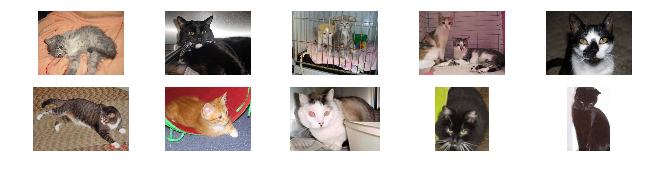

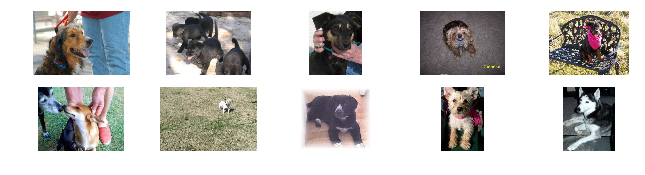

In [11]:
train_cats = os.path.join(train_data_dir,'cats')
train_dogs = os.path.join(train_data_dir,'dogs')

def viz_dir(dirpath):
    image_paths = os.listdir(dirpath)

    fig, axs = plt.subplots(2,5, figsize=(11,2.5))
    for i, img_path in enumerate(np.random.choice(image_paths, 10, replace=False)):
        img = Image.open(os.path.join(dirpath, img_path))
        ax = axs[i//5, i%5]
        ax.imshow(img)
        ax.axis('off')
        
viz_dir(train_cats)
viz_dir(train_dogs)

In [19]:
# dimensions of our images.
img_width, img_height = 150, 150

nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [20]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
visualize_keras_model(model)

In [21]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [22]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

model.save_weights('first_try.h5')

Epoch 1/50
125/125 [==============================] - 63s - loss: 0.7083 - acc: 0.5180 - val_loss: 0.6837 - val_acc: 0.5600
Epoch 2/50
125/125 [==============================] - 63s - loss: 0.6743 - acc: 0.5945 - val_loss: 0.6255 - val_acc: 0.6575
Epoch 3/50
125/125 [==============================] - 63s - loss: 0.6278 - acc: 0.6685 - val_loss: 0.5950 - val_acc: 0.6713
Epoch 4/50
125/125 [==============================] - 63s - loss: 0.6042 - acc: 0.6945 - val_loss: 0.5901 - val_acc: 0.6900
Epoch 5/50
125/125 [==============================] - 62s - loss: 0.5762 - acc: 0.7020 - val_loss: 0.5672 - val_acc: 0.7113
Epoch 6/50
125/125 [==============================] - 62s - loss: 0.5739 - acc: 0.7040 - val_loss: 0.5809 - val_acc: 0.6763
Epoch 7/50
125/125 [==============================] - 63s - loss: 0.5411 - acc: 0.7185 - val_loss: 0.6514 - val_acc: 0.6825
Epoch 8/50
125/125 [==============================] - 62s - loss: 0.5439 - acc: 0.7380 - val_loss: 0.5720 - val_acc: 0.6975
Epoch 9/

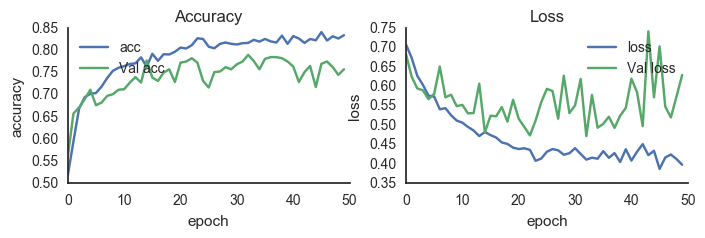

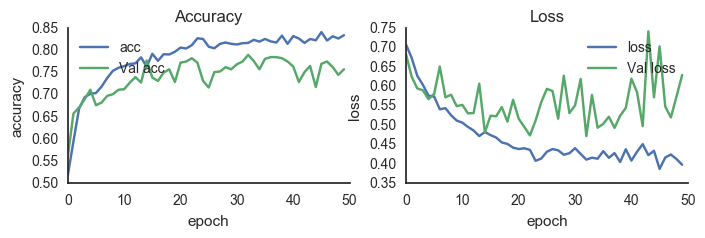

In [32]:
plot_training_curves(history.history);

# Using a pre-trained model

Based on https://gist.github.com/fchollet/f35fbc80e066a49d65f1688a7e99f069


In [40]:
from keras.preprocessing.image import ImageDataGenerator
from keras import applications

top_model_weights_path = 'bottleneck_fc_model.h5'
nb_train_samples = 2000
nb_validation_samples = 800

epochs = 50
batch_size = 16

In [41]:
def save_bottlebeck_features():
    datagen = ImageDataGenerator(rescale=1. / 255)

    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_train = model.predict_generator(
        generator, nb_train_samples // batch_size)
    np.save(open('bottleneck_features_train.npy', 'w'),
            bottleneck_features_train)

    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_validation = model.predict_generator(
        generator, nb_validation_samples // batch_size)
    np.save(open('bottleneck_features_validation.npy', 'w'),
            bottleneck_features_validation)

In [44]:
def train_top_model():
    train_data = np.load(open('bottleneck_features_train.npy'))
    train_labels = np.array(
        [0] * (nb_train_samples / 2) + [1] * (nb_train_samples / 2))

    validation_data = np.load(open('bottleneck_features_validation.npy'))
    validation_labels = np.array(
        [0] * (nb_validation_samples / 2) + [1] * (nb_validation_samples / 2))

    model = Sequential()
    # Note: train_data.shape = (2000, 4, 4, 512)
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels))
    model.save_weights(top_model_weights_path)
    return history

In [43]:
save_bottlebeck_features()

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


Train on 2000 samples, validate on 800 samples
Epoch 1/50
2000/2000 [==============================] - 4s - loss: 0.7059 - acc: 0.7485 - val_loss: 0.3210 - val_acc: 0.8562
Epoch 2/50
2000/2000 [==============================] - 4s - loss: 0.3585 - acc: 0.8530 - val_loss: 0.3264 - val_acc: 0.8475
Epoch 3/50
2000/2000 [==============================] - 4s - loss: 0.2921 - acc: 0.8815 - val_loss: 0.2575 - val_acc: 0.9050
Epoch 4/50
2000/2000 [==============================] - 4s - loss: 0.2550 - acc: 0.9035 - val_loss: 0.2496 - val_acc: 0.9075
Epoch 5/50
2000/2000 [==============================] - 4s - loss: 0.2094 - acc: 0.9180 - val_loss: 0.3554 - val_acc: 0.8675
Epoch 6/50
2000/2000 [==============================] - 4s - loss: 0.2162 - acc: 0.9185 - val_loss: 0.2952 - val_acc: 0.9050
Epoch 7/50
2000/2000 [==============================] - 4s - loss: 0.1648 - acc: 0.9390 - val_loss: 0.3583 - val_acc: 0.8838
Epoch 8/50
2000/2000 [==============================] - 4s - loss: 0.1717 - ac

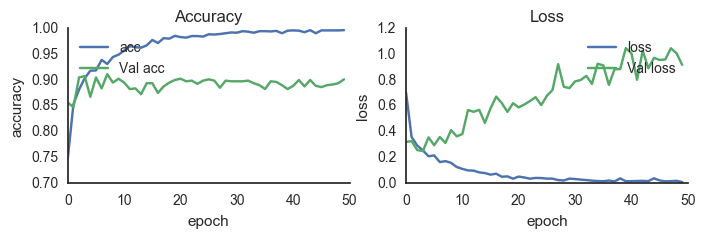

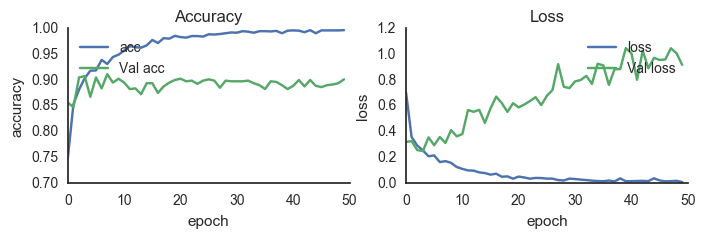

In [45]:
history = train_top_model()

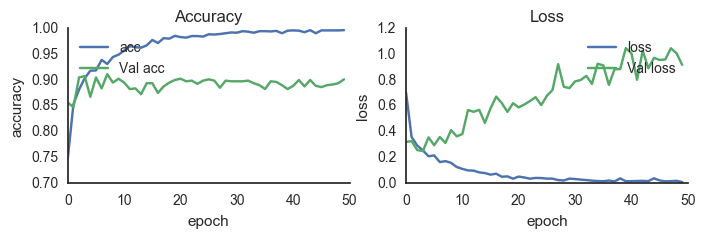

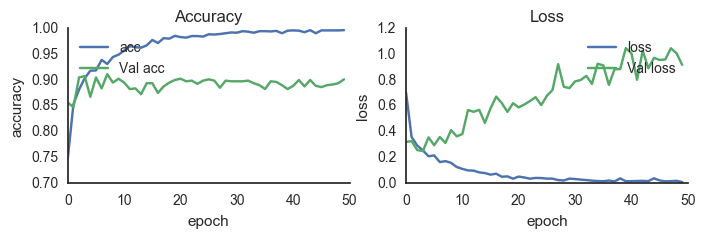

In [46]:
plot_training_curves(history.history);

90% accuracy in just a couple of minutes! Nice.

# Fine-tuning the whole network

Based on https://gist.github.com/fchollet/7eb39b44eb9e16e59632d25fb3119975

In [85]:
# Reset things...
from keras.layers.core import K
K.clear_session() 

In [86]:
# path to the model weights files.
weights_path = os.path.expanduser('~/.keras/models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

epochs = 50
batch_size = 16

In [87]:
# build the VGG16 network
base_model = applications.VGG16(weights='imagenet', 
                           include_top=False,
 # Add below line to gist to fix error:
 # ValueError: The shape of the input to "Flatten" is not fully
 # defined (got (None, None, 512). We can use our own
 # width and height because we're only keeping the convolutional layers
                           input_shape=(img_height,img_width,3))
print('Model loaded.')

Model loaded.


In [88]:
# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

In [89]:
# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning
top_model.load_weights(top_model_weights_path)

In [90]:
# add the model on top of the convolutional base
model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

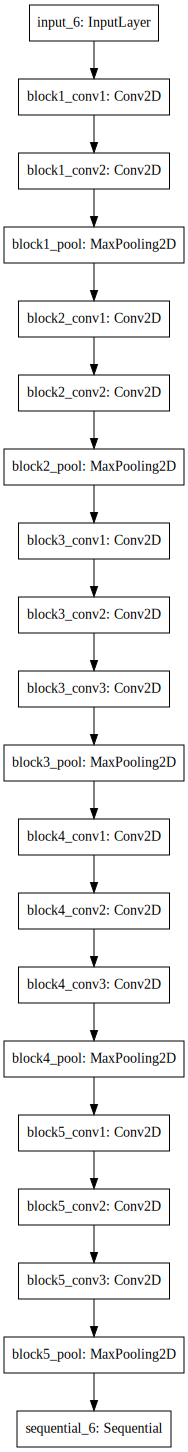

In [81]:
# Now we have the VGG model with our own layer on top
visualize_keras_model(model)

In [84]:
# Easier to count layers in this form. We want to freeze the first 
# 4 conv->pool blocks, which works out to be the first 15 layers
# (note that Keras blog post says 25--seems like a typo!)
model.layers

In [92]:
# set the first 15 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model.layers[:15]:
    layer.trainable = False

# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [93]:
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [98]:
# fine-tune the model
epochs = 20
history = model.fit_generator(
    train_generator, 
    steps_per_epoch=nb_train_samples/batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples/batch_size)

Epoch 1/20
125/125 [==============================] - 577s - loss: 0.2388 - acc: 0.9130 - val_loss: 0.3235 - val_acc: 0.8988
Epoch 2/20
125/125 [==============================] - 573s - loss: 0.1830 - acc: 0.9285 - val_loss: 0.2424 - val_acc: 0.9187
Epoch 3/20
125/125 [==============================] - 573s - loss: 0.1459 - acc: 0.9430 - val_loss: 0.2830 - val_acc: 0.9250
Epoch 4/20
125/125 [==============================] - 581s - loss: 0.1297 - acc: 0.9480 - val_loss: 0.3086 - val_acc: 0.9175
Epoch 5/20
125/125 [==============================] - 584s - loss: 0.1142 - acc: 0.9605 - val_loss: 0.3165 - val_acc: 0.9287
Epoch 6/20
125/125 [==============================] - 583s - loss: 0.1284 - acc: 0.9545 - val_loss: 0.3874 - val_acc: 0.9137
Epoch 7/20
125/125 [==============================] - 584s - loss: 0.1186 - acc: 0.9585 - val_loss: 0.4440 - val_acc: 0.9113
Epoch 8/20
125/125 [==============================] - 583s - loss: 0.0984 - acc: 0.9670 - val_loss: 0.3336 - val_acc: 0.9163


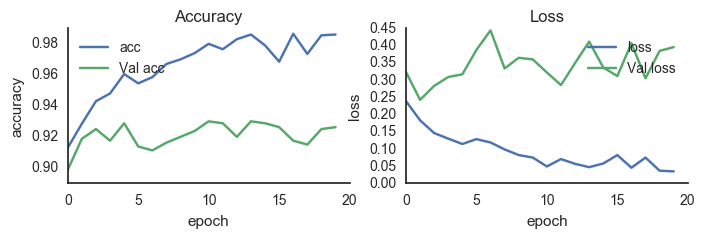

In [100]:
plot_training_curves(history.history);

In [102]:
full_model_weights_path = 'full_model_weights.h5'
model.save_weights(full_model_weights_path)

We got a couple of percent lift on validation accuracy. We'll stop here for now. To improve further, we could try:

- increasing dropout or other regularization and train more
- using data augmentation for the pre-trained model as well
- fine tuning more of the VGG model (though we'd want to fight overfitting more)